In [ ]:
import torch
import os
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
import random
from PIL import Image
from torch.utils.data import DataLoader
import numpy as np
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset
from torch.nn import Conv2d, ReLU, MaxPool2d, Flatten, Linear, Dropout, BatchNorm2d
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_DEVICES = torch.cuda.device_count()
NUM_WORKERS = os.cpu_count()

NUM_CLASSES = 47
BATCH_SIZE = 16
APPLY_SHUFFLE = True
WIDTH = 224
HEIGHT = 224

INPUT_SHAPE = (256, 256, 3)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kacpergregorowicz/house-plant-species")

print("Path to dataset files:", path)

100%|██████████| 4.85G/4.85G [04:25<00:00, 19.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kacpergregorowicz/house-plant-species/versions/4


In [ ]:
DATA_PATH = os.path.join(path, "house_plant_species")

TRAIN_PATH = os.path.join('/root/.cache/splitted_datasets', 'train')
VALID_PATH = os.path.join('/root/.cache/splitted_datasets', 'valid')

In [ ]:
def random_data_sample_plotter(data_dir):

  data_files_paths = []

  for class_name in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, class_name)):

      data_files_paths.append(os.path.join(data_dir, class_name, file))

  random.shuffle(data_files_paths)

  selected_files = data_files_paths[:40]

  for i, file in enumerate(selected_files):
    img = Image.open(file)

    plt.subplot(4, 10, i+1)

    plt.imshow(img)
    plt.axis('off')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1) # Adjust spacing for better visual
  plt.show()

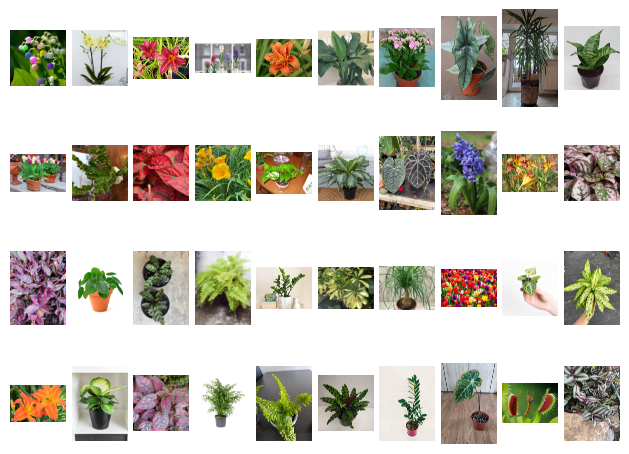

In [ ]:
random_data_sample_plotter(DATA_PATH)

Text(0.5, 1.0, 'number of images per each class')

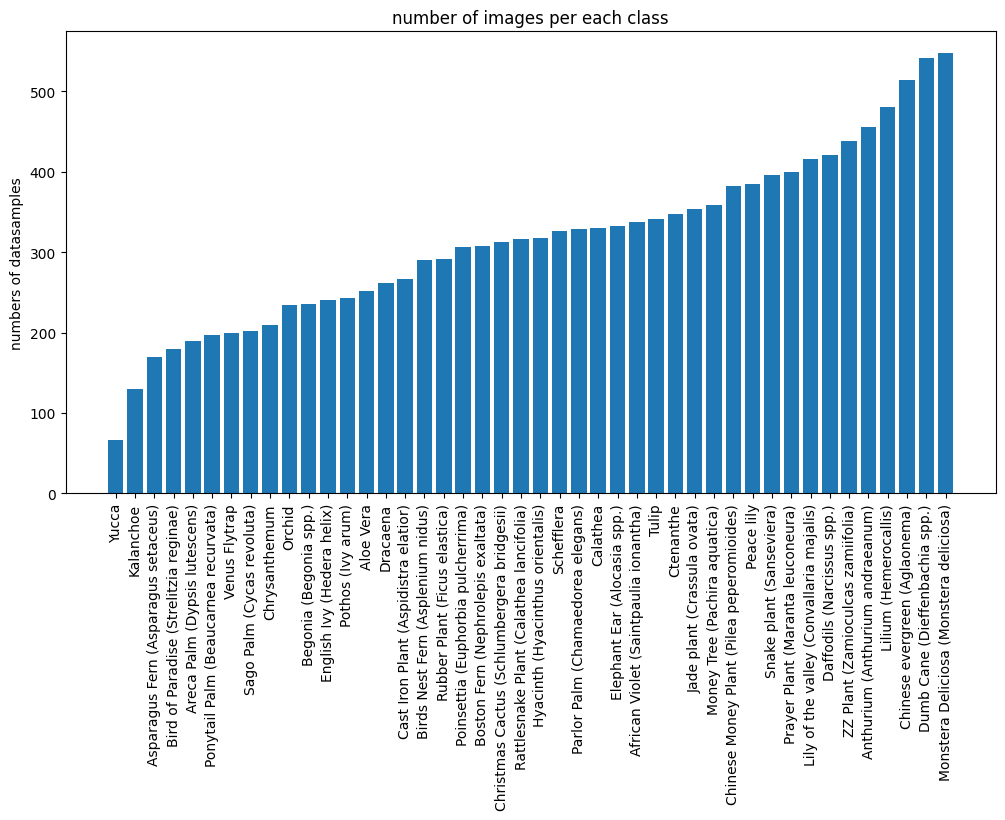

In [ ]:
label_mapping = {len(os.listdir(os.path.join(DATA_PATH, label))) : label for label in os.listdir(DATA_PATH)}
label_nums = [i for i in label_mapping.keys()]

sorted_labels = [label_mapping[label] for label in sorted(label_nums)]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted(label_nums))
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('numbers of datasamples')
plt.title('number of images per each class')

In [ ]:
def train_test_split(data_dir, train_path, valid_path, train_rato):

  for class_name in os.listdir(data_dir):
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_path, class_name), exist_ok=True)

    class_nums = 0
    class_filenames = []
    for file in os.listdir(os.path.join(data_dir, class_name)):
      class_nums +=1
      class_filenames.append(os.path.join(data_dir, class_name, file))

    train_nums = int(class_nums * train_rato)

    train_filenames = class_filenames[train_nums:]
    valid_filenames = class_filenames[:train_nums]

    for train_file in train_filenames:
      shutil.copy(train_file, os.path.join(train_path, class_name))

    for valid_file in valid_filenames:
      shutil.copy(valid_file, os.path.join(valid_path, class_name))



In [ ]:
train_test_split(DATA_PATH, TRAIN_PATH, VALID_PATH, 0.1)

In [ ]:
transformer = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop((HEIGHT, WIDTH), padding=4),
    transforms.ToTensor(),
])

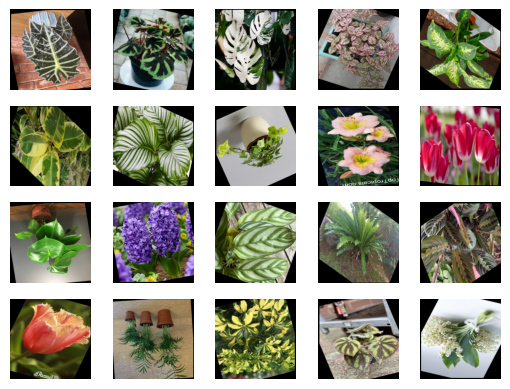

In [ ]:
examples = [os.path.join(DATA_PATH, class_name, file)
for class_name in os.listdir(DATA_PATH)
  for file in os.listdir(os.path.join(DATA_PATH, class_name))]

random.shuffle(examples)
examples = examples[:20]



for i,file in enumerate(examples):
  img = Image.open(file).convert('RGB')
  aug = transformer(img)

  plt.subplot(4, 5, i+1)
  plt.imshow(aug.permute(1, 2, 0))
  plt.axis('off')
plt.show()


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_paths, transform=None, label_mapping=None):
        self.file_paths = file_paths
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)

        image = image.convert('RGB')

        class_name = os.path.basename(os.path.dirname(img_path))

        label = self.label_mapping[class_name]

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def cross_validator_and_trainer(data_path=None, model=None, n_splits=None, train_dir=None, transform=None, epochs=None):
  kfold = KFold(shuffle=True, n_splits=n_splits, random_state=42)

  labels = os.listdir(train_dir)
  label_mapping = {label_name:index for index, label_name in enumerate(labels)}

  train_image_paths = [os.path.join(train_dir, class_name, file)
                       for class_name in labels
                       for file in os.listdir(os.path.join(train_dir, class_name))]

  random.shuffle(train_image_paths)

  fold_train_accuracies,fold_train_losses = [], []
  fold_valid_accuracies, fold_valid_losses = [], []

  for train_indexes, valid_indexes in kfold.split(train_image_paths):
    train_files = [train_image_paths[i] for i in train_indexes]
    valid_files = [train_image_paths[i] for i in valid_indexes]

    train_dataset = ImageDataset(train_files, transformer, label_mapping)
    valid_dataset = ImageDataset(valid_files, transformer, label_mapping)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


    for epoch in range(epochs):
      print(f'training model for epoch:[{epoch}/{epochs}]')

      model.train()

      train_running_loss = 0.0
      train_correct = 0
      train_total = 0

      for images, labels in train_dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

      train_accuracy = train_correct / train_total
      train_loss = train_running_loss / len(train_dataloader)

      fold_train_accuracies.append(train_accuracy)
      fold_train_losses.append(train_loss)

      print(f"Epoch [{epoch+1}/{epochs}] =>=>=>=>=>=>=>=> Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
      print(f"train_correct: {train_correct}, train_total: {train_total}")

      model.eval()

      valid_running_loss = 0.0
      valid_correct = 0
      valid_total = 0

      with torch.no_grad():
        for images, labels in valid_dataloader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)

          outputs = model(images)
          loss = criterion(outputs, labels)

          valid_running_loss += loss.item()
          _, predictions = torch.max(outputs, 1)
          valid_correct += (predictions == labels).sum().item()
          valid_total += labels.size(0)

        valid_accuracy = valid_correct / valid_total
        valid_loss = valid_running_loss / len(valid_dataloader)

        fold_valid_accuracies.append(valid_accuracy)
        fold_valid_losses.append(valid_loss)

        scheduler.step(valid_loss)


  print(f'Average Accuracy from Cross-Validation: {np.mean(fold_valid_accuracies):.4f}')

  return fold_train_accuracies, fold_train_losses, fold_valid_accuracies, fold_valid_losses, epochs*n_splits

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b83a2ad9b2c7049de1c205156a969df882e9fcf58bee955c79d4c1c3698c80c4
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [ ]:
import torch
import torch.nn as nn
from torch.nn import Conv2d, BatchNorm2d, ReLU, Dropout, AdaptiveAvgPool2d, MaxPool2d
import torchvision.models as models
from efficientnet_pytorch import EfficientNet



class CustomEnsembleModel(torch.nn.Module):
  def __init__(self, num_classes = 47):
    super(CustomEnsembleModel, self).__init__()
    self.resnet50 = models.resnet50(pretrained=True)
    self.efficient_net =   EfficientNet.from_pretrained('efficientnet-b0')

    self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])

    self.custom_resnet = nn.Sequential(
        Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1, bias=False),
        BatchNorm2d(1024),
        ReLU(inplace=True),
        Dropout(p=0.5),
        MaxPool2d(kernel_size=3, stride=2),

        Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, bias=False),
        BatchNorm2d(512),
        ReLU(inplace=True),
        Dropout(p=0.5),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    self.custom_effnet = nn.Sequential(
            Conv2d(1280, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNorm2d(1024),
            ReLU(inplace=True),
            Dropout(p=0.5),
            MaxPool2d(kernel_size=3, stride=2),

            Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNorm2d(512),
            ReLU(inplace=True),
            Dropout(p=0.5),
            AdaptiveAvgPool2d((1, 1))
      )

    self.fc = nn.Linear(512, num_classes)

  def forward(self, x):
     x1 = self.resnet50(x)
     x1 = self.custom_resnet(x1)
     x1 = torch.flatten(x1, 1)
     x1 = self.fc(x1)

     x2 = self.efficient_net.extract_features(x)
     x2 = self.custom_effnet(x2)
     x2 = torch.flatten(x2, 1)
     x2 = self.fc(x2)

     return (x1 + x2) / 2

In [ ]:
model = CustomEnsembleModel(num_classes=NUM_CLASSES).to(DEVICE)

model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|████

Loaded pretrained weights for efficientnet-b0


CustomEnsembleModel(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="")

In [ ]:
fta, ftl, fva, fvl, epochs = cross_validator_and_trainer(model=model, n_splits=5, train_dir=TRAIN_PATH, transform=transformer, epochs=3)

loading data
data loaded
training model for epoch:[0/3]
Epoch [1/3] =>=>=>=>=>=>=>=> Loss: 1.9339, Accuracy: 0.5766
train_correct: 6149, train_total: 10664
training model for epoch:[1/3]
Epoch [2/3] =>=>=>=>=>=>=>=> Loss: 0.7649, Accuracy: 0.8191
train_correct: 8735, train_total: 10664
training model for epoch:[2/3]
Epoch [3/3] =>=>=>=>=>=>=>=> Loss: 0.5125, Accuracy: 0.8712
train_correct: 9291, train_total: 10664
loading data
data loaded
training model for epoch:[0/3]
Epoch [1/3] =>=>=>=>=>=>=>=> Loss: 0.4269, Accuracy: 0.8874
train_correct: 9464, train_total: 10665
training model for epoch:[1/3]
Epoch [2/3] =>=>=>=>=>=>=>=> Loss: 0.3322, Accuracy: 0.9143
train_correct: 9751, train_total: 10665
training model for epoch:[2/3]
Epoch [3/3] =>=>=>=>=>=>=>=> Loss: 0.2750, Accuracy: 0.9285
train_correct: 9902, train_total: 10665
loading data
data loaded
training model for epoch:[0/3]
Epoch [1/3] =>=>=>=>=>=>=>=> Loss: 0.2675, Accuracy: 0.9264
train_correct: 9880, train_total: 10665
training

In [ ]:
import os
import torch

# Create the directory if it doesn't exist
os.makedirs("/root/.cache/model", exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), "/root/.cache/model/house_plant_species_detector.pth")


FileExistsError: [Errno 17] File exists: '/root/.cache/s_logs/'

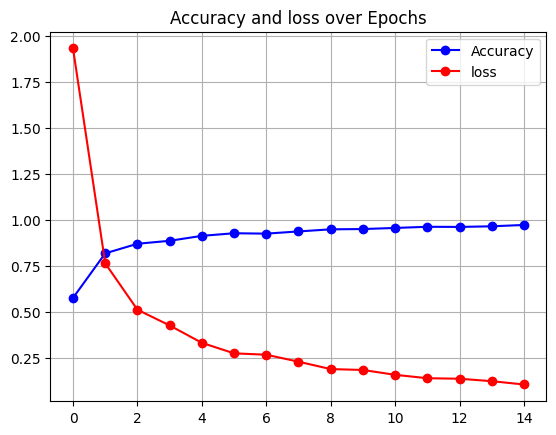

In [ ]:
os.makedirs('/root/.cache/s_logs')
plt.plot(np.arange(epochs), fta, marker='o', linestyle='-', color='b', label='Accuracy')
plt.plot(np.arange(epochs), ftl, marker='o', linestyle='-', color='r', label='loss')

plt.title('Accuracy and loss over Epochs')
plt.legend()
plt.grid(True)

os.makedirs('/root/.cache/s_logs/')
plt.savefig('/root/.cache/s_logs/accuracy_loss_plot.png')

plt.show()

In [ ]:
valid_filepaths = [os.path.join(VALID_PATH, class_name, file) for class_name in os.listdir(VALID_PATH) for file in os.listdir(os.path.join(VALID_PATH, class_name))]

# Create a mapping from class names to indexes
label_mapping = {label_name: index for index, label_name in enumerate(os.listdir(VALID_PATH))}

validation_dataset = ImageDataset(valid_filepaths, transformer, label_mapping)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
# Set the model to evaluation mode
model.eval()
model = model.to(DEVICE)
# Initialize a list to store predictions
all_predictions = []

with torch.no_grad():
    for data in validation_loader:
        inputs, _ = data  # Assuming your dataset returns (input, label) tuples
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        # Append predictions to the list
        all_predictions.extend(predicted.tolist())


In [ ]:
valid_class_names = []

for class_name in os.listdir(VALID_PATH):
    for file in os.listdir(os.path.join(VALID_PATH, class_name)):
        valid_class_names.append(class_name)

mapped_indexes = [label_mapping[class_name] for class_name in valid_class_names]


<Figure size 1000x1000 with 0 Axes>

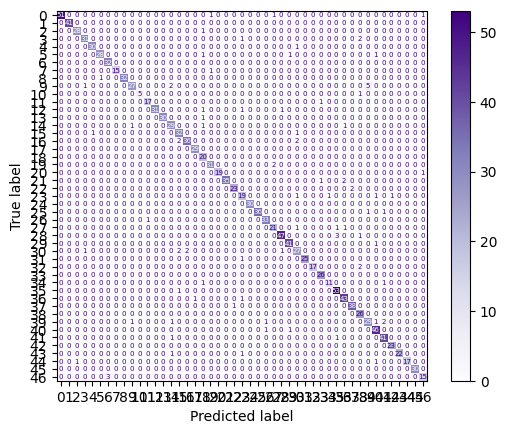

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(mapped_indexes, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Set the figure size before plotting
plt.figure(figsize=(10, 10))  # Adjust the figsize as needed

# Plot with custom font size for annotations
disp.plot(cmap='Purples', values_format='d', text_kw={'fontsize': 5})  # Adjust the fontsize as needed

plt.savefig('/root/.cache/logs/conf_matrix.jpg')
plt.show()


In [ ]:
import shutil

# Compress the folder
shutil.make_archive("/root/.cache/zip_logs", 'zip', "/root/.cache/logs")

from google.colab import files

# Download the zip file
files.download("/root/.cache/zip_logs.zip")

In [ ]:
from google.colab import files

# Download the file
files.download('/root/.cache/model/house_plant_species_detector.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/root/.cache/logs/accuracy_loss_plot.png')

In [ ]:
label_mapping = {index:label_name for index, label_name in enumerate(os.listdir(TRAIN_PATH))}
label_mapping

{0: 'Monstera Deliciosa (Monstera deliciosa)',
 1: 'Lily of the valley (Convallaria majalis)',
 2: 'Birds Nest Fern (Asplenium nidus)',
 3: 'Tradescantia',
 4: 'Rattlesnake Plant (Calathea lancifolia)',
 5: 'Christmas Cactus (Schlumbergera bridgesii)',
 6: 'Parlor Palm (Chamaedorea elegans)',
 7: 'Asparagus Fern (Asparagus setaceus)',
 8: 'African Violet (Saintpaulia ionantha)',
 9: 'Money Tree (Pachira aquatica)',
 10: 'Yucca',
 11: 'Bird of Paradise (Strelitzia reginae)',
 12: 'Polka Dot Plant (Hypoestes phyllostachya)',
 13: 'Hyacinth (Hyacinthus orientalis)',
 14: 'Schefflera',
 15: 'Ctenanthe',
 16: 'Prayer Plant (Maranta leuconeura)',
 17: 'Rubber Plant (Ficus elastica)',
 18: 'Chrysanthemum',
 19: 'Elephant Ear (Alocasia spp.)',
 20: 'Sago Palm (Cycas revoluta)',
 21: 'Peace lily',
 22: 'Aloe Vera',
 23: 'Begonia (Begonia spp.)',
 24: 'Poinsettia (Euphorbia pulcherrima)',
 25: 'Chinese Money Plant (Pilea peperomioides)',
 26: 'Tulip',
 27: 'Pothos (Ivy arum)',
 28: 'Chinese ever

In [ ]:
labels = os.listdir(TRAIN_PATH)
label_mapping = {index:label_name for index, label_name in enumerate(labels)}

In [ ]:
label_mapping

{0: 'Monstera Deliciosa (Monstera deliciosa)',
 1: 'Lily of the valley (Convallaria majalis)',
 2: 'Birds Nest Fern (Asplenium nidus)',
 3: 'Tradescantia',
 4: 'Rattlesnake Plant (Calathea lancifolia)',
 5: 'Christmas Cactus (Schlumbergera bridgesii)',
 6: 'Parlor Palm (Chamaedorea elegans)',
 7: 'Asparagus Fern (Asparagus setaceus)',
 8: 'African Violet (Saintpaulia ionantha)',
 9: 'Money Tree (Pachira aquatica)',
 10: 'Yucca',
 11: 'Bird of Paradise (Strelitzia reginae)',
 12: 'Polka Dot Plant (Hypoestes phyllostachya)',
 13: 'Hyacinth (Hyacinthus orientalis)',
 14: 'Schefflera',
 15: 'Ctenanthe',
 16: 'Prayer Plant (Maranta leuconeura)',
 17: 'Rubber Plant (Ficus elastica)',
 18: 'Chrysanthemum',
 19: 'Elephant Ear (Alocasia spp.)',
 20: 'Sago Palm (Cycas revoluta)',
 21: 'Peace lily',
 22: 'Aloe Vera',
 23: 'Begonia (Begonia spp.)',
 24: 'Poinsettia (Euphorbia pulcherrima)',
 25: 'Chinese Money Plant (Pilea peperomioides)',
 26: 'Tulip',
 27: 'Pothos (Ivy arum)',
 28: 'Chinese ever